# Big Data Analysis Project - Group Project FS2020
## University of Zurich
## 5th of June 2020

Jara Fuhrer, 15-702-889

Claudio Brasser, 14-921-746

Severin Siffert, 14-720-536

Andrea Giambonini, 10-726-842

Olajoke Oladipo, 17-722-414


## "The goal of the project is to apply the data science pipeline"

![title](doingDS.png)

# Data Collection / Acquisition

Our dataset comes from http://www.kave.cc/, where 15'000 hours of interaction data from the Visual Studio plugin ReSharper (a popular tool to program in C#) was collected in almost 11 million events from voluntaries.
To see what kind of data is collected, you can look at the data schema here: http://www.kave.cc/feedbag/event-generation.

Within this project, we focus on three events:
- build event: actions like build, build all, or clean
- edit event: changes made by the developer, like renaming
- test run event: which tests where run when and with what result


#### Who constructed data set, when, why?
The KaVE Project originally was a German research program. Over the past 10 years, it evolved into a platform for research around recommendation systems for software engineering. Generally, they're interested in questions like how users influence software engineering or how certain tools can support users to perform their tasks better.
Examples are intelligent code completion, interaction trackers or evaluation tools.

The KaVE are collecting and providing these data sets such that we can better understand what software engineers do / what they interact with / how theyre using an IDE / where their problems lie and so on. With this data, we can try to see relations between the working behaviour of developers and his efficienty / performance / productivity / habits etc.

Further below, the three data sets which we extracted from the gigantic pile of possibilities, are explained.

#### What do we want to learn from this data?
From personal experience, we know how important it is to frequently build your code and run some tests. Only then you're able to link what you've done (i.e. what you've coded, the edit events) to the outcome (i.e. (hopefully) working code, build and test run events). 

* Often repeated advice: compile early, compile often
* Intuition: longer time and more edits between tests/builds = more chance to screw something up
* Is there a way to show that empirically?

Our goal of this data analysis therefore is to analyze the link between the probability of Unit tests or project builds succeeding in connection with how much time has passed and how many edits were made since the last build/test run.


#### Hypotheses

We want to test the advice 'compile early, compile often' and the closely related 'test a lot' empirically. In order to do this we found three relevant events in the data: edit (code modified), build and test events.

Our hypotheses are:

1. Build
    * The longer a developer waits to build his code, the higher the probability that the build will fail
    * The more edit events a developer executes, the lower the probability that the build will succeed
2. Test   
    * The longer a developer waits to run some tests, the higher the probability for test failures
    * The more edit events a developer executes, the lower the probability for test success


# Data Preprocessing / Cleaning

The data was originally available in individual json events, with great support for parsing with Java or C#. 
Using the accompanying Java examples we converted the JSON-formatted data into .csv files in order to have an easy import into Pandas Dataframes available.
This resulted in a dataset consisting out of 3 different files, one for each type of event.

The more simple part of the preprocessing stage included discarding wrong, incomplete, and unneeded data, parsing timestamps into a Python-compatible format, and storing the data into new, cleaned csv files. 

## Session Splitting

The main challenge in the preprocessing stage turned out to be session splitting. In our dataset, each record describes an <i>event</i> in the IDE, triggered by a programmer. Now each event also contains a *sessionID* attribute. This attribute will be the same for each event triggered without the progammer closing his IDE or even shutting down his computer. So naturally, a session could range from a few minutes duration (e.g. if the programmer restarts his computer right away) to really long timespans. We could tell that some programmers close their IDE only for forced Windows updates. 
Because we want to track actual development time, we decided to call it a new session if no code was modified for five minutes. We did this by introducing a variable called `SESSION_TIMEOUT_SECONDS = 300`, which denotes how long a session can be kept alive without any events triggered by the programmer. We also introduced a variable `MAX_SESSION_DURATION = 60`, which denotes the maximum number of minutes a single session can have before being split. 

For this splitting of sessions to work, all 3 data files have to be considered and upon finding a session that needs to be split, all records from the same session with a timestamp greater than the splitting point will have to be split as well. Thus, to make the preprocessing more simple, we aggregated the data from all 3 datasets into a single data structure and ordered them by their session ID. By switching the data structure to numpy arrays from Pandas Dataframes we were able to cut the preprocessing time from multiple hours into a maximum of several minutes. We attribute this performance increase mostly to the rather slow read and iteration speed on dataframes, when compared to numpy arrays. 


Example:


---


SESSION_TIMEOUT_SECONDS = 60

record A: sessionID = 1, timestamp = 05.05.2020 - 16:00:00 - edit

record B:  sessionID = 1, timestamp = 05.05.2020 - 16:00:30 - edit

record C:  sessionID = 1, timestamp = 05.05.2020 - 18:00:00 - build

record D:  sessionID = 1, timestamp = 05.05.2020 - 18:00:45 - test


---


In this example, the first two edit events clearly belong to the same session, as the follow 30 seconds after one another. Record C has a timestamp much later in the day though. When our algorithm arrives at record C, it will assign a newly generated (unique) sessionID to the record because `recordC.timestamp - recordB.timestamp > SESSION_TIMEOUT_SECONDS`. Additionally, record D will still have the timestamp of the original sessionID assigned to it, which is now wrong since we split the session up beforehands. This means that we will have to find all events *after* the splitting point and assign the new ID to them as well. From this point on we continue on from record D with the same procedure. Thus it might very well be the case that a session is split into multiple sub-sessions and some records might be changed several times. 

After this procedure is finished the data is again split into 3 dataframes, which are stored in one .csv file respectively. 
 
This Notebook only imports the data after this cleanup has happened. The preprocessing code was omitted in this report, as it is rather long and does not contribute that much to the analysis part. The code is attached to the submission in the file `preprocessing.py`.

In [67]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from itertools import islice
from sklearn import datasets, linear_model, model_selection, metrics
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.tools.tools as sm
import statsmodels.api as sm1
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import warnings 
warnings.filterwarnings("ignore")

In [3]:
df_edit = pd.read_csv(r'..\data\df_edit.csv', low_memory=False)
df_test = pd.read_csv(r'..\data\df_test.csv', low_memory=False)
df_build = pd.read_csv(r'..\data\df_build.csv', low_memory=False)

# if there are problems loading the data, try out those lines
# df_edit = pd.read_csv(r'../BigdataProject/df_edit_fixed.csv', low_memory=False)
# df_test = pd.read_csv(r'../BigdataProject/df_test_fixed.csv', low_memory=False)
# df_build = pd.read_csv(r'../BigdataProject/df_build_fixed.csv', low_memory=False)

# Data Exploration

Each row in our dataset is a sessionID-timestamp pair for the respective event category (build, test or edit). For Build events we know in addition if the event succeded or not (boolean) and for test events we know how many unit test were run at a specific time and how many of those succeded.

Let's take a closer look at the data:

### Edit Events

Edit events are triggered whenever code gets modified in some way. This covers typing on the keyboard, using refactoring tools and executing commands that change the code. For example if I copy/paste a line, that triggers an edit event, just like when I auto generate a bunch of getters and setters.

In [4]:
print(f' This dataset contains {len(df_edit)} edits events')
df_edit.iloc[:,1:].tail()

 This dataset contains 497459 edits events


,sessionID,timestamp,type
497454,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:31:53,edit
497455,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:47:53,edit
497456,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:02,edit
497457,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:12,edit
497458,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:20,edit


### Test Events

Test events are written whenever the button to run unit tests is clicked. The events record the timing, how many tests were executed, and how many actually succeeded. Test events that have 0 tests run can happen when no tests are selected to run or when test execution is cancelled before the first one completes.

In [5]:
print(f' This dataset contains {len(df_test)} test events.','\n',f'SessionID-timestamp run, in average, {round(df_test.iloc[:,4].mean(),1)} tests and in average over all sessionID-timestamp pair, {round((df_test.iloc[:,5].mean()/df_test.iloc[:,4].mean())*100,1)}% are "passed" tests.')
df_test.iloc[:,1:].tail()

 This dataset contains 3826 test events. 
 SessionID-timestamp run, in average, 88.8 tests and in average over all sessionID-timestamp pair, 86.3% are "passed" tests.


,sessionID,timestamp,type,totalTests,testsPassed
3821,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:45:37,test,478.0,0.0
3822,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:46:16,test,478.0,475.0
3823,fadb490b-cc30-4690-8ecd-ae5c818fb1e1,2016-08-31 11:57:20,test,92.0,92.0
3824,fbcdffc5-b444-4262-bbb6-52c091caea79,2016-07-17 12:18:13,test,0.0,0.0
3825,ff816b40-f797-4065-a6ef-94abb564e92c,2016-12-20 10:48:00,test,0.0,0.0


### Build Events

Build events are triggered whenever some part of the code is compiled. This is usually before running tests, before running the program, and before starting a debugging session.

In [6]:
print(f' This dataset contain {len(df_build)} build events.','\n',f'In average, {round(len(df_build.loc[df_build["buildSuccessful"]==True])/len(df_build)*100,1)}% are succeddful build.')
df_build.iloc[:,1:].tail()

 This dataset contain 14957 build events. 
 In average, 86.2% are succeddful build.


,sessionID,timestamp,type,buildSuccessful
14952,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:01:13,build,False
14953,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:01:32,build,True
14954,ff7bee9b-075d-4139-b782-65d1587da5c9,2016-10-18 09:43:34,build,True
14955,ff9890a9-60d7-41f5-a655-95527ee6f4b7,2016-11-21 14:07:51,build,False
14956,ffb030c9-c0ff-42bd-9e04-6c4b44f5ab79,2016-05-10 16:14:55,build,True


Unfortunately, we are not yet ready to build our model. In order to test our hypotheses we need to reprocess the data to find:
1. The time passed between two build/test events
2. The number of edits between build/test events

### Before we start processing the data, let's have a closer look at the test dataframe

Let's take a look at the relations between totalTests and testsPassed.

 The correlation between the two independent variables is 0.97


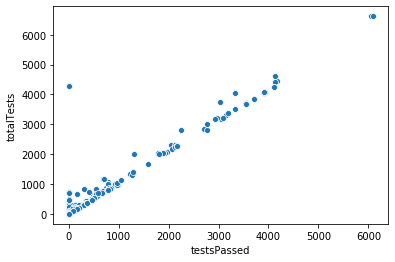

In [7]:
sns.scatterplot(x="testsPassed",y = "totalTests",data=df_test)
print(f' The correlation between the two independent variables is {round(df_test["testsPassed"].corr(df_test["totalTests"]),2)}')

The relationship between total tests and passed tests is positive linear. From only looking at the plot, one can say that it is a rather strong correlation. As calculated, there is indeed a high correlation of 97%. This indicates that most of the data has a (close to) 100% passed-test score.

In terms of outliers, there are only a few on the left side in the middle (around 4000 totalTests).

This graph makes sense to us: Generally speaking, the number of passed tests should in the worst case stay the same, in the better case increase as the number of total tests goes up. 

A decreasing ratio of passedTests to totalTests (i.e. more and more tests fail) would indicate that the more tests you run, the more errors you detect in your code.

Of course there is also the invariant of `Tests run >= Tests passed`.

In [9]:
count_samples = len(df_test)
count_zeroPassedTests= len(df_test[df_test["testsPassed"]==0])
print(f'Total number of samples in df_test: {count_samples}')
print(f'Number of samples that have zero passed tests: {count_zeroPassedTests}')

count_zeroTotalTests = len(df_test[df_test["totalTests"] == 0])
count_zeroPassedTestNotZeroTotalTests = len(df_test[(df_test["testsPassed"] == 0) 
                        & (df_test["totalTests"] > 0 )])
print(f'Number of samples that have zero total tests and therefore also zero passed tests: {count_zeroTotalTests} ({round(count_zeroTotalTests/count_samples,2)*100}%)')

print(f'We can see that there are {count_zeroPassedTestNotZeroTotalTests} failed test runs due to actually failed single test and not only because there werent any tests run.\n')

print('The two outliers on the left of the scatterplot are:')
outliers = df_test[(df_test["totalTests"] > 4000) 
                        & (df_test["testsPassed"] <3000)]
print(outliers)

df_test[df_test["testsPassed"]==0].head()

print('\n\nLets quickly also look whether there are negative total tests - which wouldnt make sense and could tamper our analysis later on:')
count_negativeTotalTest = len(df_test[df_test["totalTests"] < 0])
print(count_negativeTotalTest)
print(f'Yes there is! There is one entry with a negative number of total tests run:\n')
print(df_test[df_test["totalTests"] < 0].head())
print('\nThis entry is very strange, since it doesnt have a timestamp allocated.')


Total number of samples in df_test: 3826
Number of samples that have zero passed tests: 1260
Number of samples that have zero total tests and therefore also zero passed tests: 74 (2.0%)
We can see that there are 1186 failed test runs due to actually failed single test and not only because there werent any tests run.

The two outliers on the left of the scatterplot are:
      Unnamed: 0 sessionID            timestamp  type  totalTests  testsPassed
1890        2200      4382  2016-09-26 13:44:24  test      4284.0         13.0
1892        2202      4383  2016-09-26 14:00:00  test      4284.0          0.0


Lets quickly also look whether there are negative total tests - which wouldnt make sense and could tamper our analysis later on:
1
Yes there is! There is one entry with a negative number of total tests run:

      Unnamed: 0         sessionID timestamp  type  totalTests  testsPassed
3819        3806  f5decb96-f8e5-4f       NaN  test        -1.0         -1.0

This entry is very strange, 

We revealed another interesting remark: Why are there test events with zero totalTests? It could be that the dataset defines a test event not only if a test was actually run completely, but also when it only was started. For example: If a developer starts a test but aborts it before it completed, then there is a test event with still zero total tests, since it couldnt finish. 

They only constitute 2% of the df_test samples, but still we were asking ourselves whether we should remove them. As we see later on in the processing, we will need to calculate the ratio passed tests / total tests, which tells us whether or not a test run was successful (i.e. the probability of success). From this ratio, we then derive whether the test run was successful = 1 (ratio = 100%) or failed = 0(ratio <100%). If total test is 0, we cannot perform this calculation and thus have to insert either 0 or 1 for this "test result boolean".

- Inserting a 0 = failed test run for those events dont seem logical, since we only consider the probability of test passing after a successful test. If for example, 0 edits have been executed after a successful test run, the next test run includes 0 total tests and we would insert 0, it would mean that without any edits of the developer, the test run suddenly failed.
- Inserting a 1 = successful test run could tamper our regressions. If for example all those samples with 0 total tests have a lot of number of edits between two test runs, models could interpret that these many edits led to the test success - however in reality, no tests have been executed.

We decided to remove those 74 sample points plus the one with no timestamp and -1 total tests from the data set, since we want to prevent jeopardising our models.

In [10]:
# removes all samples that have 0 total tests
# attention: overwrites df_test !!
df_test = df_test[df_test['totalTests'] > 0]
length_df_test = len(df_test)
print(f'The lengh of the df_test is now: {length_df_test}')

The lengh of the df_test is now: 3751


Now that we had know the characteristics of the test events, we should start processing the data. There will follow some more correlation analysis once we've processed the data.

## Processing the data in order to predict Build success

The first reflection to do is about which session should be consider in our analysis. We are interested in what happens between two consecutives events, but should we consider any subsequent build events?
We decided to only consider what happens from a successful build to the next build. The reason for this choice is that we want to start from a 'stable' state and analyze how the probability of obtaining another stable state (i.e. Successful Build) is affected by how much changes we made. If we didn't start from a 'stable' state, our result might be biased by other changes in the past which made the state 'unstable' (not passed Build).

Now we can start processing our Data as follow:

* For each sessionID:
    1. get timestamp of the last successfull build
    2. get timestamp of next build after 1)
        * if there is a 2) > 1) then:
    3. get the time passed between 1) and 2)
    4. count number of edits between the timestamp 1) and 2)
        * else we dont take 1) into account
* Create a new DataFrame with following variables:
    - sessionID
    - timestamp of the successful Build event
    - timestamp of the next Build event (next build after the successful Build event)
    - time passed between the successful Build and the next Build event (in seconds)
    - edits between the successful Build and the next Build event
    - result of the next (after a successful Build) build event (boolean)


In [11]:
def get_all_build(sessionID):
    all_build = df_build[df_build["sessionID"] == sessionID]
    return all_build.sort_values(["timestamp"]).values

In [12]:
def get_successful_build(sessionID):
    all_successful_build = df_build[(df_build["sessionID"] == sessionID) & (df_build["buildSuccessful"] == True)] 
    return all_successful_build.sort_values(["timestamp"]).values

In [13]:
def get_nr_edits_between_build(sessionID,timeLastSuccessfullBuild, timeNextBuild):
    totalEdit = df_edit[df_edit["sessionID"] == sessionID]
    totalEdit = totalEdit.sort_values(["timestamp"])
    editBetweenSuccessBuildAndBuild = totalEdit[(totalEdit["timestamp"] <= timeNextBuild) & (totalEdit["timestamp"] >= timeLastSuccessfullBuild)]
    return editBetweenSuccessBuildAndBuild["timestamp"].values.size

In [14]:
def edits_from_pass_to_next_build(sessionID):
    result = []

    # get all successful build of session 
    allSuccessfulBuild = get_successful_build(sessionID)
    allBuild = get_all_build(sessionID)
    numOfSuccessfulBuild = np.size(allSuccessfulBuild,0)
    numOfBuild = np.size(allBuild,0)
    # iterate over each passed build
    for s in range(numOfSuccessfulBuild):
        # if build follows, count edits
        if allBuild[-1][2]>allSuccessfulBuild[s][2]:
            for b in range(numOfBuild):
                if allBuild[b][2]>allSuccessfulBuild[s][2]:
                    break
                    
            timeLastSuccessfulBuild=allSuccessfulBuild[s][2]
            timeNextBuild=allBuild[b][2]
            resultNextBuild=allBuild[b][4]
            nrOfEdit=get_nr_edits_between_build(sessionID,timeLastSuccessfulBuild, timeNextBuild)
            sessionID = allBuild[b][1]
            time_passed = pd.Timedelta(datetime.strptime(timeNextBuild, '%Y-%m-%d %H:%M:%S')-datetime.strptime(timeLastSuccessfulBuild, '%Y-%m-%d %H:%M:%S')).seconds
            if nrOfEdit==0:
                pass
            else:
                result.append([sessionID, timeLastSuccessfulBuild, timeNextBuild, time_passed, nrOfEdit, resultNextBuild])
            
    return result

In [15]:
#Iterate over all sessions and create DataFrame
final_result=[]
allSessionID=df_build.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    Observations = edits_from_pass_to_next_build(sessionID)
    NrOfObservations = len(Observations)
    # take only sessionID with at least 1 successful build and at least 1 build after that  
    if NrOfObservations > 0:
        for Obs in Observations:
            final_result.append(Obs)
print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-06-04 16:26:12.921431 

time after loop: 2020-06-04 16:32:03.194422 



In [17]:
#create DataFrame
column_labels = ['sessionID','timestampSuccessBuild','timestampNextBuild','time_passed', '#editsUntilNextBuild', 'nextBuildResult']
new_df_build = pd.DataFrame(final_result, columns=column_labels)
#show the new DataFrame
new_df_build.tail()

,sessionID,timestampSuccessBuild,timestampNextBuild,time_passed,#editsUntilNextBuild,nextBuildResult
9557,fe8caa7d-fbb6-494c-aedb-ecbf22ff8a91,2016-07-25 18:17:02,2016-07-25 18:20:21,199,18,True
9558,fe8caa7d-fbb6-494c-aedb-ecbf22ff8a91,2016-07-25 18:20:21,2016-07-25 18:22:36,135,12,True
9559,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:06,2016-04-02 22:00:28,22,5,True
9560,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:28,2016-04-02 22:00:47,19,2,True
9561,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:47,2016-04-02 22:01:13,26,5,False


In [18]:
new_df_build.isnull().any()

sessionID                False
timestampSuccessBuild    False
timestampNextBuild       False
time_passed              False
#editsUntilNextBuild     False
nextBuildResult          False
dtype: bool

##### Further data exploration
Now that we have our build dataset we can explore our data better. First, we look at the distribution of how many builds actually succeed and how often builds happen.

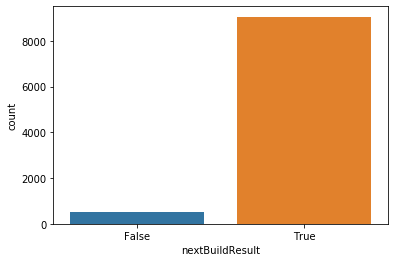

Only 5.3% of the build-events fail


In [19]:
sns.countplot(x="nextBuildResult",data=new_df_build)
plt.show()
count_failedBuild = len(new_df_build[new_df_build["nextBuildResult"]==False])
count_passedBuild = len(new_df_build[new_df_build["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'Only {pct_failedBuild}% of the build-events fail')

In [20]:
new_df_build.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","median","max","min"],"time_passed":["count","mean","median","max","min"]})

#editsUntilNextBuild                            time_passed  \
                               count       mean median  max min       count   
nextBuildResult                                                               
False                            507  19.879684      8  249   1         507   
True                            9055  12.329652      6  286   1        9055   

                                              
                       mean median   max min  
nextBuildResult                               
False            248.238659    117  2082   1  
True             160.658421     81  2879   1

First remarks:
* Our classes (successful vs. unsuccessful Build events) are strongly imbalanced.
* The average number of edits and the average time passed for unsuccessful Build are more then twice as much as for successful Build. This seems to support our hypothesis.
* However our variable "number of edits" and "time passed" between builds events seem to be strongly positive skewed.
* We did not expect builds to happen that often. We have a median of less than 2 minutes between builds, which might also explain why many builds succeed.

Let's try to visualize the timings

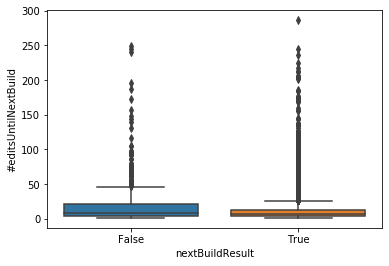

In [21]:
sns.boxplot(x=new_df_build["nextBuildResult"], y=new_df_build["#editsUntilNextBuild"])

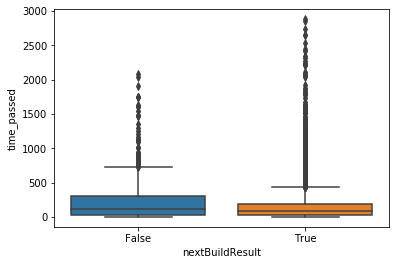

In [22]:
sns.boxplot(x=new_df_build["nextBuildResult"], y=new_df_build["time_passed"])

This Bloxplot representation show us that many datapoint are recognize as possible outliers. Let's try to consider only observation with at most 100 edits and less than 1200 seconds between Build event to remove some of the noise.

96.1% of the unsuccessful build events have less than 101 edits and less then 20 min between the two Build events
98.8% of the successful build events have less than 101 edits and less then 20 min between the two Build events


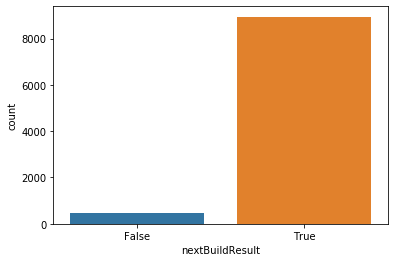

Only 5.2% of the build-events fail if we consider this restricted dataset.


In [23]:
new_df_build1=new_df_build.loc[(new_df_build["#editsUntilNextBuild"]<100) & (new_df_build["time_passed"]<1200)]
print(f'{round(len(new_df_build1[new_df_build1["nextBuildResult"]==False])/len(new_df_build[new_df_build["nextBuildResult"]==False])*100,1)}% of the unsuccessful build events have less than 101 edits and less then 20 min between the two Build events')
print(f'{round(len(new_df_build1[new_df_build1["nextBuildResult"]==True])/len(new_df_build[new_df_build["nextBuildResult"]==True])*100,1)}% of the successful build events have less than 101 edits and less then 20 min between the two Build events')

sns.countplot(x="nextBuildResult",data=new_df_build1)
plt.show()
count_failedBuild = len(new_df_build1[new_df_build1["nextBuildResult"]==False])
count_passedBuild = len(new_df_build1[new_df_build1["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'Only {pct_failedBuild}% of the build-events fail if we consider this restricted dataset.')

Given that we already considered possible problems within sessionID and we already splitted many sessionID using our session_timeout indicator, we don't see any reasonable reasons to further restrict our dataset. Therefore we decided to continue our analysis with the whole dataset.  

## Process the data in order to predict the probability of a successful test 

For the analysis of the relationship between the A) number of edits done or B) the time passed between two tests and the success of a test, we again want to have this "stable" state: We only consider the number of edits done / time passed after a successful test.

Now, the question arose how to define a "successful" test. There are two possibilities:
- a test run is successful if all the tests were successful, i.e. passedTests over totalTests equals to 1
- a test run is successful if at least 1 test was successful, i.e. passesTests over totalTests lies between 0 and 1

We decided on classifying a test run only successful when 100% of the tests passed. With the second definition, the spectrum of a successful test would be too big (a test run with 5% passed tests would be considered just as successful as a test run with 100%). This decision of calling a test successful with 100% passing tests also goes along well with the definition of a successful build (there are no partial successful builds).

In order to predict the probability of a successful test run, we need the two data sets "df_edit" and "df_test". The latter has a column "testsPassed" which gives us the information whether to consider a particular session or not: It has to be equal to the total numbers of tests run such that it reached this 100% passed tests.


To process our data, we defined several auxiliary functions which generally speaking do the following:

* For each sessionID:
    - get all entries that have passed tests equal total tests
* For each sessionID with a passed test run:
    - count the number of edits done until the next test run
    - here, we don't differentiate passed or failed tests, since that's exactly what we're interested in. 
* Create a new DataFrame with the following variables:
    - sessionID
    - timeTestPass: timestamp when a test passed
    - timeNextTest: timestamp of the next test run of this sessionID
    - editsUntilNextTest: number of edits done from timePass until timeNext
    - ratio_p_t: result of the next test run. Ratio = passedTestNext/totalTestsNext, i.e. the percentage of passed tests
    - totalTestsNext: total tests run in the next test (which was at timeNext)
    - testPassedNext: number of tests passed in the next test (which was at timeNext)
    - nextTestResult: boolean which is true if 100% of the tests passed = test was successful, otherwise false


### Processing of edit and test data set
First, count the number of edits since last successful tests run

In [24]:
# counts the numbers of edits between a test and the next test
# for our purpose, be aware to only call it with the first test being successful, i.e. 100%
def get_nr_edits_between_tests(sessionID, timeFirstTest , timeNextTest):
    result = df_edit[(df_edit["timestamp"] < timeNextTest)
                                 & (df_edit["timestamp"] > timeFirstTest) 
                                 & (df_edit["sessionID"] == sessionID)]
    result = np.asarray(result)
    return len(result)

Prepare a method to create a DataFrame with 9 columns

In [25]:
def create_df(resultArray):
    # Create DataFrame
    column_labels = ['sessionID','timeTestPass','timeNextTest','timePassed','editsUntilNextTest', 
                     'ratio_p_t','totalTestsNext', 'testPassedNext' ,'nextTestResult']
    df = pd.DataFrame(resultArray, columns=column_labels)
    return df;

#### Now iterate over all sessions and create a DataFrame

In [26]:
# Creates a DF and returns a list that contains among other things
# the nr of edits from a passing test until the next test event and whether this next test has been successful
def get_edits_tests_list():
    successfulTestRuns=0
    unsuccessfulTestRuns=0
    successfulTestRunsWithNextTest=0
    sessionWithPassedTestsButNoNextTest=0
    result=[]
    # sort the data frame by sessionID and then by timestamp
    df_test_sorted = df_test.sort_values(by=['sessionID'])
    df_test_sorted = df_test.sort_values(by=['timestamp'])

    print(f'Iterate over {len(df_test_sorted)} data entries')
    i=0
    for index, row in df_test_sorted.iterrows():
        # only for test runs with 100% passed-test score  
        if(row["testsPassed"] == row["totalTests"]):
            successfulTestRuns+=1
            #has next test
            if((i+1 < len(df_test_sorted)) and (df_test_sorted.iloc[i+1].sessionID == row["sessionID"])):
                successfulTestRunsWithNextTest+=1
                item=[]
                timestampNext=df_test_sorted.iloc[i+1].timestamp
                time_passed = pd.Timedelta(datetime.strptime(timestampNext, '%Y-%m-%d %H:%M:%S')
                                           -datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')).seconds
                totalTestsNext=df_test_sorted.iloc[i+1].totalTests
                passedTestNext=df_test_sorted.iloc[i+1].testsPassed
                nrOfEdits=get_nr_edits_between_tests(row["sessionID"], row["timestamp"], timestampNext)
                if(passedTestNext == totalTestsNext):
                    resultTestNextBoolean = 1
                else:
                    resultTestNextBoolean = 0
                if(totalTestsNext != 0):
                    ratioPT = (passedTestNext/totalTestsNext)
                else:
                    # if no tests have been executed, we define this as successful test run
                    ratioPT = 1
                item.append(row["sessionID"])
                item.append(row["timestamp"])
                item.append(timestampNext)
                item.append(time_passed)
                item.append(nrOfEdits)
                item.append(float(ratioPT))
                item.append(int(totalTestsNext))
                item.append(int(passedTestNext))
                item.append(int(resultTestNextBoolean))
                result.append(item)
            else:
                sessionWithPassedTestsButNoNextTest+=1
        else:
            unsuccessfulTestRuns+=1
        i+=1
    print(f'SessionIDs with successful test runs: {successfulTestRuns}')
    print(f'SessionIDs with successful test runs and next a test run: {successfulTestRunsWithNextTest}')
    print(f'SessionIDs with passed test but no next test: {sessionWithPassedTestsButNoNextTest}')
    print(f'SessionIDs with unsuccessful test runs: {unsuccessfulTestRuns}')
    
    return result

In [27]:
edits_tests = get_edits_tests_list()

Iterate over 3751 data entries
SessionIDs with successful test runs: 1340
SessionIDs with successful test runs and next a test run: 994
SessionIDs with passed test but no next test: 346
SessionIDs with unsuccessful test runs: 2411


In [30]:
df_edits_tests = create_df(edits_tests)
df_edits_tests.tail()

,sessionID,timeTestPass,timeNextTest,timePassed,editsUntilNextTest,ratio_p_t,totalTestsNext,testPassedNext,nextTestResult
989,5ce3748f-c14c-4fdd-8cdc-cc81a2a7964d,2017-01-23 11:06:52,2017-01-23 11:07:03,11,1,1.00000,157,157,1
990,5ce3748f-c14c-4fdd-8cdc-cc81a2a7964d,2017-01-23 11:07:03,2017-01-23 11:07:28,25,1,0.99392,2796,2779,0
991,ac5adb1c-f8a0-4a50-990f-0319419d28ea,2017-01-26 13:29:52,2017-01-26 13:30:35,43,5,0.00000,1,0,0
992,10605,2017-02-08 07:32:43,2017-02-08 07:33:45,62,9,1.00000,21,21,1
993,7118,2017-02-09 11:05:36,2017-02-09 11:05:57,21,2,1.00000,174,174,1


### Now that we have our processed data set, we can analyze the data further

#### Explore the processed data "edits_tests"

Let's have a look a the "nextTestResult" value, which says whether or not a test run after a successful test was successful too = 100% passed-test score. Please note that we defined a test run which didnt include any tests (totalTests = 0) as successful (=1).

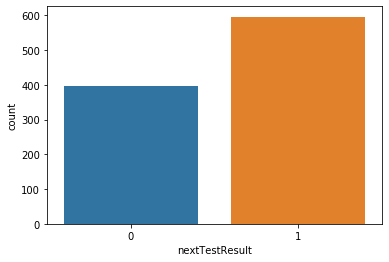

40.0% of the tests events after a successful test run fail. 60.0% were successful.


In [31]:
sns.countplot(x="nextTestResult",data=df_edits_tests)
plt.show()
count_failedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==False])
count_passedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==True])
pct_failedTests = round(count_failedTests/(count_failedTests+count_passedTests)*100,1)
print(f'{pct_failedTests}% of the tests events after a successful test run fail. {100-pct_failedTests}% were successful.')

This distribution can also be explored by a histogram:

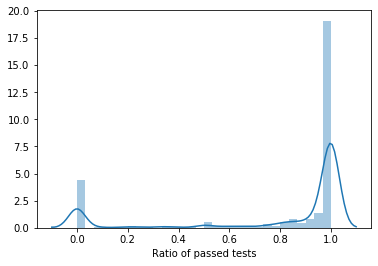

In [32]:
sns.distplot(df_edits_tests.ratio_p_t,
             axlabel='Ratio of passed tests')

The histogram doesnt show a normal distribution. The data is rather left skewed, i.e. most of the samples are clustered on the right side. However, the long tail on the left gets "interrupted". 

Let's therefore take a closer look at the extreme on the left, where the ratio is 0.


We've deleted all the test runs with zero total tests. Therefore, a ratio of 0 can only occur when 0 tests have passed within a test run.

In [33]:
count_0tests = len(df_edits_tests[df_edits_tests["totalTestsNext"]==0])
print(f'Number of test runs with 0 tests: {count_0tests} (As expected)')
count_0passedTests = len(df_edits_tests[df_edits_tests["testPassedNext"]==0])
print(f'There are {count_0passedTests} test runs with zero passed tests  ({round(count_0passedTests/len(df_edits_tests),4)*100}%).\n')


Number of test runs with 0 tests: 0 (As expected)
There are 143 test runs with zero passed tests  (14.39%).



Let's look at the distribution of the result successful/unsuccessful when only 1 single test is run. Because in this case, the ratio either can be 0 or 1 - our two extremes.

In [34]:
count_totalFailedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==0])
print(f'In total, {count_totalFailedTests} test run failed.\n')

count_totalTestsNextOnly1 = len(df_edits_tests[df_edits_tests["totalTestsNext"] == 1])
count_failedOnly1 = len(df_edits_tests[(df_edits_tests["totalTestsNext"] == 1) 
                        & (df_edits_tests["nextTestResult"] == 0 )])
count_failedMoreThan1 = len(df_edits_tests[(df_edits_tests["totalTestsNext"] > 1 ) 
                        & (df_edits_tests["nextTestResult"] == 0 )])
total_test_runs = len(df_edits_tests)

print(f'In total, there are {count_totalTestsNextOnly1} test runs which contain 1 single test ({round(count_totalTestsNextOnly1/total_test_runs,2)*100}%).\n')
print(f'Out of these {count_totalTestsNextOnly1} runs, {count_failedOnly1} tests ({round(count_failedOnly1/count_totalTestsNextOnly1,1)*100}%) failed.\n')
print(f'This means that {round(count_failedOnly1/count_totalFailedTests, 1)*100}% of the failed tests come from test runs which contain only 1 single test.') 


In total, 398 test run failed.

In total, there are 402 test runs which contain 1 single test (40.0%).

Out of these 402 runs, 116 tests (30.0%) failed.

This means that 30.0% of the failed tests come from test runs which contain only 1 single test.



The fact that one third of the test runs include only one test partially explains the two higher bins on the left and right side of the histogram: If there is only one test run, the ratio of passed tests can only be 1 or 0. 

This histogram furthermore indicates that mostly related tests were run. Otherwise, we would see way more samples that lie inbetween 0 and 1.

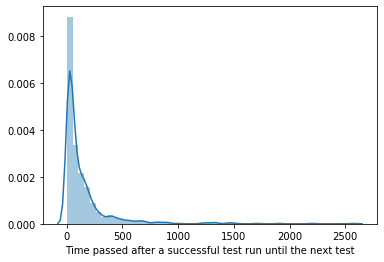

In [35]:
sns.distplot(df_edits_tests.timePassed,
             axlabel='Time passed after a successful test run until the next test')

The histogram of the time passed between two tests is right skewed. For most of the samples, the time passed is between 0 and 500 seconds. Later on, we see more concrete values.

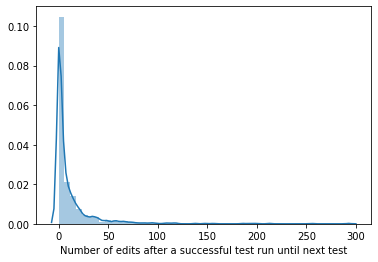

In [36]:
sns.distplot(df_edits_tests.editsUntilNextTest,
             axlabel='Number of edits after a successful test run until next test')

Just as the time passed, the number of edits between two tests is righ skewed too.

Let's look at the distribution of the number of edit events and time passed with regard to the percentage of pasesd tests.

Text(0, 0.5, 'number of edits')

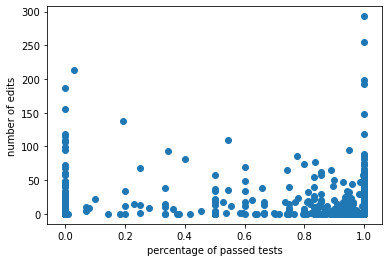

In [37]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,4] # nr of edits
y = edits_tests_array[:,5] # ratio

plt.scatter(y,x)
plt.xlabel('percentage of passed tests') 
plt.ylabel('number of edits') 

Text(0, 0.5, 'time passed between two tests')

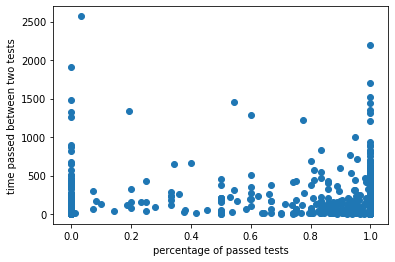

In [38]:
x = edits_tests_array[:,3] # timepassed
y = edits_tests_array[:,5] # ratio

plt.scatter(y,x)
plt.xlabel('percentage of passed tests') 
plt.ylabel('time passed between two tests') 

We see that the both scatterplots look very similar. The data points seem to be more or less evenly distributed over the x-axis (but still with more samples on the right, i.e. with higher pass-total-ratio). This observation leads us to a first assumption that neither the number of edits nor the time passed between the test runs might have a great influence on the probability of test success. But first, let's analyse further...

How does the relation between number of edits and time passed look like?


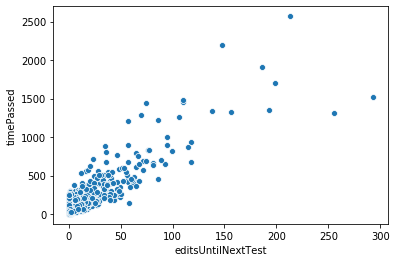

In [39]:
sns.scatterplot(x="editsUntilNextTest", y ="timePassed", data=df_edits_tests)

We can identify a positive correlation between the number of edits and the time passed between a successful test and the next test run. Which is reasonable: The more edits a developer performs, the more time passes until a new test run is started. We can therefore expect that both time passed and edits between two test runs will have a similar influence on whether or not the next test run succeeds.

Furthermore, we can identify some heteroscedasticity: The variability of timePassed is not constant across the number of edits (less variability with low number of edits and large variability with large number of edits).

##### Means of ratio, edits and time passed

In [40]:
ratio_p_t_mean = df_edits_tests["ratio_p_t"].mean()
pct_ratio_p_t_mean = round(ratio_p_t_mean*100,1)
print(f'The mean ratio of passed tests over total tests is {pct_ratio_p_t_mean}%. This means that in general, over two third of the tests passed within a single test run.\n')

edits_mean = round(df_edits_tests["editsUntilNextTest"].mean(),1)
print(f'On average, {edits_mean} edits were executed before a new test and after a successful test run.\n')


time_passed_mean = round(df_edits_tests["timePassed"].mean(),1)
print(f'The mean time passed between two tests is {time_passed_mean} seconds, so approximately {round(time_passed_mean/60)} minutes.\n')


The mean ratio of passed tests over total tests is 79.8%. This means that in general, over two third of the tests passed within a single test run.

On average, 11.8 edits were executed before a new test and after a successful test run.

The mean time passed between two tests is 144.3 seconds, so approximately 2 minutes.



Lets look closer at the variables we are mostly interested in "editsUntilNextTest" and "timePassed":

In [41]:
df_edits_tests.groupby("nextTestResult").agg({"editsUntilNextTest":["count","mean","median","max","min"],"timePassed":["count","mean","median","max","min"]})

editsUntilNextTest                            timePassed  \
                            count       mean median  max min      count   
nextTestResult                                                            
0                             398  14.316583      3  213   0        398   
1                             596  10.114094      2  293   0        596   

                                             
                      mean median   max min  
nextTestResult                               
0               175.203518   79.5  2569   2  
1               123.607383   55.0  2197   3

Before interpreting this, let's look at the distribution of the number of edits by creating a boxplot:

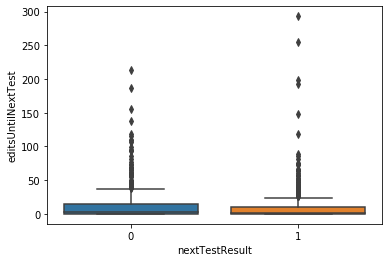

In [42]:
sns.boxplot(x=df_edits_tests["nextTestResult"], y=df_edits_tests["editsUntilNextTest"])

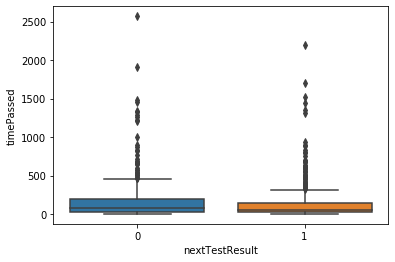

In [43]:
sns.boxplot(x=df_edits_tests["nextTestResult"], y=df_edits_tests["timePassed"])

First remarks:
* Our classes (successful vs. unsuccessful Test events) are strongly unbalanced. The successful test class has way more samples - almost 5 times more.
* However, the two classes have roughly similar median values for the number of edits - not really for the time passed though
* Therefore, a comparison of the two boxplots "fail" and "pass" doesnt reveal a lot of information. They both look very similar.
* However, the range/outliers differ quiet between successful and unsuccessful tests, the successful (orange) tests having more outliers.
* On average and rounded, the unsuccessful test runs have 4 more edits than the successful test runs.
* On average and rounded, 51 more seconds pass between a successful and an unsuccessful test run.
* Interesting are the median values for the number of edits. Here we see that in 50% of sessions, 3, 2, 1 or 0 edits were made (after a successful test) until the next test (since median 3), whether this next test was successful or not.
* The median of two for successful test runs indicates a highly frequent testing routine of many developers within the data collection.
* We have to keep in mind that our variables "number of edits" and "time passed" between test events are strongly positive skewed, as seen in the scatterplot above.


Despite the many obvious outliers (many data points after the upper whisker), we dont want to restrict the dataset anymore. We've already restricted sessions to a certain time by splitting up sessions that were too long.  
Hence, we take the processed data as it is, keeping in mind that we have a lot of outliers, and start with building some models!

# Modelling and Algorithm Building

Our goal of this data analysis is to analyze our hypothesis that more time or more edits between build/test events result in a lower probability of build/test succeeding. After having processed and explored the data are we now able to test our two hypothesis:
1. Build
    * the longer a developer waits to build his code, the higher the probability that the build will fail
    * the more edit events a developer executes, the lower the probability that the build will succeed
2. Test   
    * the longer a developer waits to run some tests, the higher the probability for test failures
    * the more edit events a developer executes, the lower the probability for test success

### Build Events

To model the probability of a certain event such as pass/fail the logistic regression is one of the most used model and a good benchmark for further analysis. 

In [28]:
Y = new_df_build["nextBuildResult"]
X = new_df_build[["#editsUntilNextBuild",'time_passed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary2())
print(f' The correlation between the two independent variables is {round(new_df_build["#editsUntilNextBuild"].corr(new_df_build["time_passed"]),2)}')

Optimization terminated successfully.
         Current function value: 0.204575
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.013     
Dependent Variable:  nextBuildResult   AIC:               3918.2899 
Date:                2020-06-04 16:35  BIC:               3939.7865 
No. Observations:    9562              Log-Likelihood:    -1956.1   
Df Model:            2                 LL-Null:           -1982.4   
Df Residuals:        9559              LLR p-value:       3.9802e-12
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 3.0837   0.0548 56.2993 0.0000  2.9763  3.1910
#editsUntilNextBuild -0.0077

All the coefficients are statistical significant (at 90% confidence level) and both the number of edits and the time passed have a negative effect on the probability of a successful built.  This means that, given the number of edits, the longer a developer waits to build his code, the higher the probability that the build will fail and at the same, given a certain time between two edits events, the more edit events a developer executes, the lower the probability that the build will succeed.


However we can observe that, as expected, the number of edits and the time spent between build events are strongly positively correlated. This Multicollinearity problem can cause unstable estimates in our model and therefore we decided to separately estimate the effect of our independent variable on the probability of a successful build event.

In [44]:
X_edit = new_df_build[["#editsUntilNextBuild"]]
X1_edit = sm.add_constant(X_edit)
logit_model_edit = sm1.Logit(Y, X1_edit)
result_logit_model_edit = logit_model_edit.fit()
print(result_logit_model_edit.summary2())

Optimization terminated successfully.
         Current function value: 0.204732
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.012     
Dependent Variable:  nextBuildResult   AIC:               3919.3014 
Date:                2020-06-04 16:36  BIC:               3933.6325 
No. Observations:    9562              Log-Likelihood:    -1957.7   
Df Model:            1                 LL-Null:           -1982.4   
Df Residuals:        9560              LLR p-value:       1.9960e-12
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 3.0627   0.0532 57.5246 0.0000  2.9584  3.1671
#editsUntilNextBuild -0.0118

In [45]:
X_time = new_df_build[["time_passed"]]
X1_time = sm.add_constant(X_time)
logit_model_time = sm1.Logit(Y, X1_time)
result_logit_model_time = logit_model_time.fit()
print(result_logit_model_time.summary2())

Optimization terminated successfully.
         Current function value: 0.204974
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.011     
Dependent Variable: nextBuildResult  AIC:              3923.9242 
Date:               2020-06-04 16:36 BIC:              3938.2553 
No. Observations:   9562             Log-Likelihood:   -1960.0   
Df Model:           1                LL-Null:          -1982.4   
Df Residuals:       9560             LLR p-value:      2.1109e-11
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          3.0682    0.0544  56.3493  0.0000   2.9614   3.1749
time_passed   -0.0009    0.0001  -7.4783  0.0000  -0.0012  -0.

As we can see from this two separate models, now the coefficients are statistical significant even at a 99% confidence level and both the number of edits and the time passed have stronger negative impact on the probability of a successful built. Let's have a brief look at how to interpret this coefficients..

In [46]:
import math
# effect of an increase in the #of edits by 10 units above the median
prSuccBuildwithmedNrEdit=1/(1+math.exp(-(3.0627-0.0118*new_df_build["#editsUntilNextBuild"].median())))*100
prSuccBuildwithmedTime=1/(1+math.exp(-(3.0682-0.0009*new_df_build["time_passed"].median())))*100
print(f'Given a median number of edits, the probability of a successful build is {round(prSuccBuildwithmedNrEdit,1)}%')
print(f'10 edits over the median number of edits, reduce the probability of a successful build by {round(prSuccBuildwithmedNrEdit-1/(1+math.exp(-(3.0627-0.0118*(new_df_build["#editsUntilNextBuild"].median()+20))))*100,1)} percentage points')
# marginal effect of an increase in the #time_passed by 5 minuts above the median
print(f'Given the median time passed between two build events, the probability of a successful build is {round(prSuccBuildwithmedTime,1)}%')
print(f'5 minutes over the median time passed between two build events, reduce the probability of a successful build by {round(prSuccBuildwithmedTime-1/(1+math.exp(-(3.0682-0.0009*(new_df_build["time_passed"].median()+300))))*100,1)} percentage points')

Given a median number of edits, the probability of a successful build is 95.2%
10 edits over the median number of edits, reduce the probability of a successful build by 1.2 percentage points
Given the median time passed between two build events, the probability of a successful build is 95.2%
5 minutes over the median time passed between two build events, reduce the probability of a successful build by 1.4 percentage points


Although they move in the expected (negative) direction, our two independent variables (# of edits and time passed) have a fairly marginal effect on the probability of getting a successful built event. In addition, our two models are not able to explain much of the variability in the dependent variable (very low pseudo R-Squared).

In [47]:
X_train_edit, X_test_edit, Y_train, Y_test = model_selection.train_test_split(X_edit, Y, test_size=0.1,random_state=0)
logit_model_edit=linear_model.LogisticRegression()
logit_model_edit.fit(X_train_edit, Y_train)

print('Accurancy of logistic regression classifier on test set is :{:.2f}'.format(logit_model_edit.score(X_test_edit,Y_test)))

Accurancy of logistic regression classifier on test set is :0.95


In [48]:
X_train_time, X_test_time, Y_train, Y_test = model_selection.train_test_split(X_time, Y, test_size=0.1,random_state=0)
logit_model_time=linear_model.LogisticRegression()
logit_model_time.fit(X_train_time, Y_train)

print('Accurancy of logistic regression classifier on test set is :{:.2f}'.format(logit_model_time.score(X_test_time,Y_test)))

Accurancy of logistic regression classifier on test set is :0.95


Despite the not encouraging results of our logistic regressions, we get (from both models) an accurancy of 95%. However, as we saw in the data exploration part, our dataset is strong unbalanced and this may be the main reason for this high accurancy. One approach to adressing this problem of class imbalance is to randomly resample the dataset. Following this approach, we decided to oversample the class of unsuccessful build. 

In [49]:
os = SMOTE(random_state=0)

os_data_X_edit, os_data_Y = os.fit_sample(X_train_edit,Y_train)
os_data_X_edit = pd.DataFrame(data=os_data_X_edit, columns=['#editsUntilNextBuild'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("Length of oversampled data is", len(os_data_X_edit))
print("Number of failed Build in oversampled data is", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build is", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X_edit))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X_edit))

os_data_X1_edit = sm.add_constant(os_data_X_edit)
logit_model_edit=sm1.Logit(os_data_Y,os_data_X1_edit)
result_logit_edit=logit_model_edit.fit()
print(result_logit_edit.summary2())

Length of oversampled data is 16294
Number of failed Build in oversampled data is 8147
Number of successful Build is 8147
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5
Optimization terminated successfully.
         Current function value: 0.680253
         Iterations 5
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.019     
Dependent Variable:   nextBuildResult   AIC:               22172.0843
Date:                 2020-06-04 16:36  BIC:               22187.4814
No. Observations:     16294             Log-Likelihood:    -11084.   
Df Model:             1                 LL-Null:           -11294.   
Df Residuals:         16292             LLR p-value:       2.2119e-93
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       5.0000                                         
--------------------------------------------------------------

In [50]:
os = SMOTE(random_state=0)

os_data_X_time, os_data_Y = os.fit_sample(X_train_time,Y_train)
os_data_X_time = pd.DataFrame(data=os_data_X_time, columns=['time_passed'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("Length of oversampled data is", len(os_data_X_time))
print("Number of failed Build in oversampled data is", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build is", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X_time))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X_time))

os_data_X1_time = sm.add_constant(os_data_X_time)
logit_model_time=sm1.Logit(os_data_Y,os_data_X1_time)
result_logit_time=logit_model_time.fit()
print(result_logit_time.summary2())

Length of oversampled data is 16294
Number of failed Build in oversampled data is 8147
Number of successful Build is 8147
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5
Optimization terminated successfully.
         Current function value: 0.680737
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.018     
Dependent Variable: nextBuildResult  AIC:              22187.8602
Date:               2020-06-04 16:36 BIC:              22203.2573
No. Observations:   16294            Log-Likelihood:   -11092.   
Df Model:           1                LL-Null:          -11294.   
Df Residuals:       16292            LLR p-value:      6.0083e-90
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err

In [51]:
# effect of an increase in the #of edits by 10 units above the median
prSuccBuildwithmedNrEdit=1/(1+math.exp(-(0.02235-0.0145*os_data_X_edit["#editsUntilNextBuild"].median())))*100
prSuccBuildwithmedTime=1/(1+math.exp(-(0.2258-0.0011*os_data_X_time["time_passed"].median())))*100
print(f'Given a median number of edits, the probability of a successful build is {round(prSuccBuildwithmedNrEdit,1)}%')
print(f'10 edits over the median number of edits, reduce the probability of a successful build by {round(prSuccBuildwithmedNrEdit-1/(1+math.exp(-(0.02235-0.0145*(os_data_X_edit["#editsUntilNextBuild"].median()+20))))*100,1)} percentage points')
# marginal effect of an increase in the #time_passed by 2 minuts above the median
print(f'Given the median time passed between two build events, the probability of a successful build is {round(prSuccBuildwithmedTime,1)}%')
print(f'5 minutes over the median time passed between two build events, reduce the probability of a successful build by {round(prSuccBuildwithmedTime-1/(1+math.exp(-(0.2258-0.0011*(os_data_X_time["time_passed"].median()+300))))*100,1)} percentage points')

Given a median number of edits, the probability of a successful build is 48.0%
10 edits over the median number of edits, reduce the probability of a successful build by 7.1 percentage points
Given the median time passed between two build events, the probability of a successful build is 52.9%
5 minutes over the median time passed between two build events, reduce the probability of a successful build by 8.2 percentage points


As we can see, with a balanced dataset, the #of edits and the time passed betwenn two build events have a much stronger impact on the probability of a successful build event. Even if the coefficients of our independent variable are almost the same, the coefficient for the intercept has been shrunk. This happened because (previously) the intercept value took into account the unbalanced structure of the dataset in which 95% of the observations were successful build (remember that now only 50% of the observation are successful build events).   

In [68]:
logit_model_edit=linear_model.LogisticRegression()
logit_model_edit.fit(os_data_X_edit, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model_edit.score(X_test_edit,Y_test)))

Accurancy of logistic regression classifier on test set:0.77


In [69]:
logit_model_time=linear_model.LogisticRegression()
logit_model_time.fit(os_data_X_time, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model_time.score(X_test_time,Y_test)))

Accurancy of logistic regression classifier on test set:0.74


In [54]:
Y_pred_edit = logit_model_edit.predict(X_test_edit)
confusion_matrix_edit = metrics.confusion_matrix(Y_test,Y_pred_edit)
Y_pred_time = logit_model_time.predict(X_test_time)
confusion_matrix_time = metrics.confusion_matrix(Y_test,Y_pred_time)
print('Confusion matrix for the number of edits','\n', confusion_matrix_edit)
print('Metric classification for the number of edits','\n', metrics.classification_report(Y_test,Y_pred_edit))
print('Confusion matrix for the time passed','\n', confusion_matrix_time)
print('Metric classification for the time passed','\n', metrics.classification_report(Y_test,Y_pred_time))


Confusion matrix for the number of edits 
 [[ 17  32]
 [192 716]]
Metric classification for the number of edits 
               precision    recall  f1-score   support

       False       0.08      0.35      0.13        49
        True       0.96      0.79      0.86       908

    accuracy                           0.77       957
   macro avg       0.52      0.57      0.50       957
weighted avg       0.91      0.77      0.83       957

Confusion matrix for the time passed 
 [[ 16  33]
 [218 690]]
Metric classification for the time passed 
               precision    recall  f1-score   support

       False       0.07      0.33      0.11        49
        True       0.95      0.76      0.85       908

    accuracy                           0.74       957
   macro avg       0.51      0.54      0.48       957
weighted avg       0.91      0.74      0.81       957



As expected, with a balanced dataset, the accuracy of our model has dropped by almost 20 percentage point remaining however at a fair level of 75%.

### Test Events

Now, we want to test those two hypotheses / answer those two questions:

1) linking time since last tests run to probability of tests passing 


2) linking number of edit events since last passing tests to probability of unit tests passing


To model the probability of unit test passing depending on how many edits have been done or how much time has passed between two test runs, we can try a linear regression. Nr of edits or timePassed would be the independent variable X and the ratio Pass/Total, i.e. the probabiltiy of passed tests, the dependent variable Y. 

For this linear regression, we need a 2d array with the numbers of edits and the ratio as well as the time between two test runs and the ratio. Both arrays can be done by selecting the right columns from our previously processed data.

Root mean squared error: 0.338
r2 score: -0.004


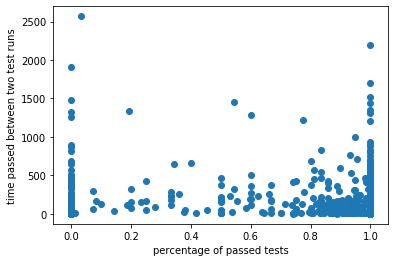

In [55]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,3] # time passed between two test runs
y = edits_tests_array[:,5] # ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(y,x) # note! we switched axis to get a nicer plot
plt.ylabel('time passed between two test runs') 
plt.xlabel('percentage of passed tests') 
plt.plot(yfit, xfit);
y_pred = model.predict(x_test[:, np.newaxis])

Rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.3f" % Rmse)
print('r2 score: %.3f' % r2_score(y_test, y_pred))

The above output shows that the RMSE is about O.36 and R-Squared of 0.010 (it changes everytime a little bit since the 20% test data samples are taken randomly). The RMSE or the standard deviation of residuals means, at 36% the data are not so concentrated around regression model line. Also, with R-Squared of about 1% , we can not justify the goodness of the model as 99% of the data point are unexplainable. This may be due to very high variance and dispersion of the data, therefore, linear regression may not be a suitable  model for this prediction.

Root mean squared error: 0.363
r2 score: -0.013


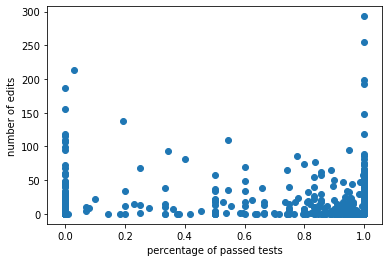

In [57]:
x = edits_tests_array[:,4] # nr of edits
y = edits_tests_array[:,5] # ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(y,x) # note! we switched axis to get a nicer plot
plt.xlabel('percentage of passed tests') 
plt.ylabel('number of edits') 
plt.plot(yfit, xfit);
y_pred = model.predict(x_test[:, np.newaxis])

print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2 score: %.3f' % r2_score(y_test, y_pred))

With simliar results from the above output, the results here shows the RMSE of about 0.34 and R-Squared of 0.019 which is almost 2% Rsquared. The same conclusion about linear regression not being a good fit for the analysis applies here as well. May be implementing a model for non-linear data would perform better.

####  Implementing ML alogrithms for non-linear data. 
Since, the parameters used for this analysis are both continuous variables, we employed Machine Learning regression models. The selected models are K-nearest Neighbor, Decision Tree, Support Vector Machine with Gaussian Kernel.

In [58]:
# Machine Learning Alogrithm
def MLRegressor(x,y):
    classifiers = [("KNN", KNeighborsRegressor(5)),
                   ("DecisionTree", DecisionTreeRegressor(max_depth=5)),
                   ("SVM Gaussian Kernel", SVR(kernel='rbf', C=1, gamma=0.1, epsilon=.1))]
    for name,model in classifiers:
        R_sqrt = []
        RMSE = []
        kf = KFold(n_splits = 5, shuffle = True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            R_sqrt.append(r2_score(y_test, model.predict(x_test)))
            RMSE.append(np.sqrt(mean_squared_error(y_test, model.predict(x_test))))
            
        print("The model performance for ",name)
        print("-------------------------------------------")
        print("R-Squared Score : ", np.mean(R_sqrt))
        print("RMSE Value : ", np.mean(RMSE))
        print("\n")

In [59]:
# time pass between two test runs as function of ratio testspassed 
x = df_edits_tests[["timePassed"]] # time passed between two test runs
y = df_edits_tests["ratio_p_t"] # ratio
MLRegressor(x,y)

The model performance for  KNN
-------------------------------------------
R-Squared Score :  -0.2051738880346488
RMSE Value :  0.3956924893954879


The model performance for  DecisionTree
-------------------------------------------
R-Squared Score :  -0.06809728244321973
RMSE Value :  0.3730412833315087


The model performance for  SVM Gaussian Kernel
-------------------------------------------
R-Squared Score :  -0.12408912310840066
RMSE Value :  0.38226547147375506




In [60]:
# number of eidts as function of ratio testspassed 
x = df_edits_tests[["editsUntilNextTest"]] # number of edits
y = df_edits_tests["ratio_p_t"] # ratio
MLRegressor(x,y)

The model performance for  KNN
-------------------------------------------
R-Squared Score :  -0.3642228207236201
RMSE Value :  0.4203304891573148


The model performance for  DecisionTree
-------------------------------------------
R-Squared Score :  -0.07892685408769055
RMSE Value :  0.37374737239020617


The model performance for  SVM Gaussian Kernel
-------------------------------------------
R-Squared Score :  -0.10065692458920332
RMSE Value :  0.37862434210097284




Suprisingly, the output performance of these ML models performed worse than that of linear regression. With all models having higher RMSE and a negative R-Squared, which sugguests the regression models are totally away from the trend of the data. As said earlier, this may be because of the very high variance, irregularites and dispersion in the data.  Further, judging based on the results from these models, We can not efficiently predict  the "ratio of testspassed" based on "time pass between two test runs" and "number of tests edits". This also sugguests, there are various other reasons to a sucessful test events that the two variables used here can not explain/model.

We create a logistic regression to model the probability of successful tests.

In [61]:
Y = df_edits_tests["nextTestResult"]
X = df_edits_tests[["editsUntilNextTest",'timePassed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary2())
print(f' The correlation between the two independent variables is {round(df_edits_tests["editsUntilNextTest"].corr(df_edits_tests["timePassed"]),2)}')

Optimization terminated successfully.
         Current function value: 0.667376
         Iterations 4
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.009    
Dependent Variable:   nextTestResult   AIC:              1332.7443
Date:                 2020-06-04 16:39 BIC:              1347.4495
No. Observations:     994              Log-Likelihood:   -663.37  
Df Model:             2                LL-Null:          -669.14  
Df Residuals:         991              LLR p-value:      0.0031407
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       4.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const               0.5434   0.0778  6.9872 0.0000  0.3909  0.6958
editsUntilNextTest  0.0047   0.0055  0.8587 0.3905 -0

Only the coefficient for time passed is statistical significant (at 90% significance level). However, just like for build-Events, our two independent variable are strongly positively correlated. This multicollinearity problem lead to very biased standard errors and p.values and for this reason we have to analyze two separate models.

In [62]:
X_edit = df_edits_tests[["editsUntilNextTest"]]
X1_edit = sm.add_constant(X_edit)
logit_model_edit = sm1.Logit(Y, X1_edit)
result_logit_model_edit = logit_model_edit.fit()
print(result_logit_model_edit.summary2())

Optimization terminated successfully.
         Current function value: 0.669981
         Iterations 4
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.005    
Dependent Variable:   nextTestResult   AIC:              1335.9228
Date:                 2020-06-04 16:39 BIC:              1345.7262
No. Observations:     994              Log-Likelihood:   -665.96  
Df Model:             1                LL-Null:          -669.14  
Df Residuals:         992              LLR p-value:      0.011750 
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       4.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const               0.4804   0.0720  6.6722 0.0000  0.3393  0.6215
editsUntilNextTest -0.0064   0.0026 -2.4395 0.0147 -0

In [63]:
X_time = df_edits_tests[["timePassed"]]
X1_time = sm.add_constant(X_time)
logit_model_time = sm1.Logit(Y, X1_time)
result_logit_model_time = logit_model_time.fit()
print(result_logit_model_time.summary2())

Optimization terminated successfully.
         Current function value: 0.667746
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.008    
Dependent Variable: nextTestResult   AIC:              1331.4791
Date:               2020-06-04 16:39 BIC:              1341.2826
No. Observations:   994              Log-Likelihood:   -663.74  
Df Model:           1                LL-Null:          -669.14  
Df Residuals:       992              LLR p-value:      0.0010195
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
const         0.5341    0.0768   6.9530  0.0000   0.3835   0.6846
timePassed   -0.0009    0.0003  -3.1491  0.0016  -0.0015  -0.0003



As we can see from this two separate models, the coefficient for timePassed and number of edits are now statistical significant at a 95% confidence level. Furhtermore, both time passed and the number of edits have a negative effect on the probability of a successful test. 

This means that, given the number of edits, the longer a developer waits to test his code, the higher the probability that the test will fail. And given a certain time between two edits events, the more edit events a developer executes, the higher the probability that the test will fail too.

However, we have to be careful in interpreting these models, since both pseudo R-squared errors are super low. Which is an indicator that neither of the two variables accurately predicts the success of the next test run.

# TODO: Final conclusion

### Technical Conclusion

The results for build and test events are rather similar and, although we tried several methods, the results achieved with our models have been quite disappointing. As supposed we could see that both the number of edits and the time passed between two build/test events have a negative impact on the probability of successful build/test events. However, we expected to find a much stronger empirical relevance confirming the often repeated advice: "compile early, compile often".   
Nevertheless we believe that there are several arguments that explain the lack of robustness of our models:
 
- Builds and tests event happen surprisingly often within sessions in the dataset.  50% of the analyzed sessions for build events have a next-build events within 2 minute and 8 edits, while test events happen even more frequently with a median of one minute and 3 edits. This means that a large part of our observations already comply with the advice "compile early, compile often" making our analysis much less effective.

- Few developers are responsible for many sessions. During inspection of the data we saw that relatively few different session ids contributed a lot to the data we used. This might stem from developers that do test driven development, which different work on the same dataset found evidence of in about 15% of the sessions.

- Other reason (like programming knowledge and experience) have a strong impact on the probability of getting successful test and build events. 



### What we've learnd in this project
- Data Cleaning is delicate: Especially at the beginning, when we didnt know the data very well, it was difficult to detect potential errors in the cleaning. It wasn't very hard to decide what to clean. Also the "how" was more or less straight forward. But the "has it been cleaned correctly?" was hard to answer. After several iterations of cleaning & testing/evaluating it, we finally could be sure that we had a good data basis to process.


- Data Processing is delicate too: Similarly to the data cleaning, it was essential to explore the data very well before processing it. We first had to define important terms such as the success of a test - when should we consider test run as successful, when unsuccessful? Also, we had to decide which cases we wanted to analyse i.e. analyse number of edits after each and every test run, or only after a successful?
    - at this point, we should have defined those important definitions earlier in the projet. For quiet some time, we didn't talked specifically about the definition of a successful test run, which lead to many code adaptions once we finally took the decision.
    

- Exploring the processed data was fun: It was nice to play a bit around with the processed data, to see whether our hypotheses at the beginning could acutally be true or if our intuition was wrong... However, visualizing this in the end was tricky too! 

- Building models: This was again very tricky. We had to try out a lot of different models since we had no clue what could actually predict the probability of test / build success.
